# <center> **PROJECT. Предсказание удовлетворённости пассажиров авиакоипаний.**

![Alt text](image-28.png)

## <center> **`1.` Постановка задачи**

**Цель работы:**

В данной работе необходимо будет, по результатам опроса клиентов авиакомпании по поводу их удовлетворённости полётом, **предсказать удовлетворённость пассажиров.**

### <center> **Организационная информация**

Проект будет состоять из шести частей:

**`1.` Постановка задачи**;

**`2.` Исследование данных**;

**`3.` Предобработка данных**;

**`4.` Разведывательный анализ данных (EDA)**;

**`5.` Отбор и преобразование признаков (Feature Engineering)**;

**`6.` Построение и сравнение моделей (Machine Learning)**.

## <center> **`2.` Исследование данных**

Импортируем необходимые библиотеки:

In [2]:
# Для работы с данными
import pandas as pd
import numpy as np
import category_encoders as ce

# Для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Для построения модели
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import metrics
import xgboost
import catboost
from catboost.utils import get_confusion_matrix

Прочитаем данные:

In [83]:
# Загружаем DataFrame
airpass_data = pd.read_csv('Прочие файлы/AirPass.csv')

# Создаём копию
airpass_df = airpass_data.copy()

In [ ]:
# Выведем первые пять строк
airpass_df.head()

Посмотрим на типизацию признаков:

In [ ]:
airpass_df.info()

Удалим столбец `Unnamed`.

In [84]:
airpass_df = airpass_df.iloc[:, 1:]

### <center> **Иформация о датасете**

Данные содержат 25 признаков и 103 904 наблюдения. Из этих 25 признаков пять — категориальные, а остальные являются непрерывными числовыми данными.

**Целевой переменной** является столбец `satisfaction`. Значение этой переменной мы и будем пытаться предсказать.

* `Gender` — пол пассажира (женский, мужской);
* `Customer Type` — тип клиента (постоянный/непостоянный клиент);
* `Age` — возраст клиента;
* `Type of Travel` — цель перелета (личная/деловая поездка);
* `Class` — туристический класс пассажира (*Business, Eco, Eco Plus*);
* `Flight distance` — расстояние полета;
* `Inflight wifi service` — уровень удовлетворённости *Wi-Fi* (0 — не применимо, 1–5);
* `Departure/Arrival time convenient` — уровень удовлетворённости временем отправления и прибытия;
* `Ease of Online booking` — уровень удовлетворённости онлайн-бронированием;
* `Gate location` — уровень удовлетворённости расположением выхода на посадку;
* `Food and drink` — уровень удовлетворённости едой и напитками;
* `Online boarding` — уровень удовлетворённости онлайн-регистрацией;
* `Seat comfort` — уровень удовлетворённости комфортом сидений;
* `Inflight entertainment` — уровень удовлетворённости развлечениями на борту;
* `On-board service` — уровень удовлетворённости сервисом на борту;
* `Leg room service` — уровень удовлетворённости местом для ног;
* `Baggage handling` — уровень удовлетворённости обработкой багажа;
* `Check-in service` — уровень удовлетворённости услугами регистрации;
* `Inflight service` — уровень удовлетворённости обслуживанием во время полёта;
* `Cleanliness` — уровень удовлетворённости чистотой;
* `Departure Delay in Minutes` — задержка при отправлении (в минутах);
* `Arrival Delay in Minutes` — задержка при прибытии (в минутах);
* `Satisfaction` — удовлетворённость авиакомпанией — целевая переменная (*satisfaction/neutral/dissatisfaction*).

Проверим данные на наличие пропусков:

In [ ]:
# Выводим столбцы с количеством пропусков
airpass_df.isnull().sum()

Суммарное количество пропусков в данных: 310 

Arrival Delay in Minutes    0.298352
dtype: float64


<AxesSubplot:>

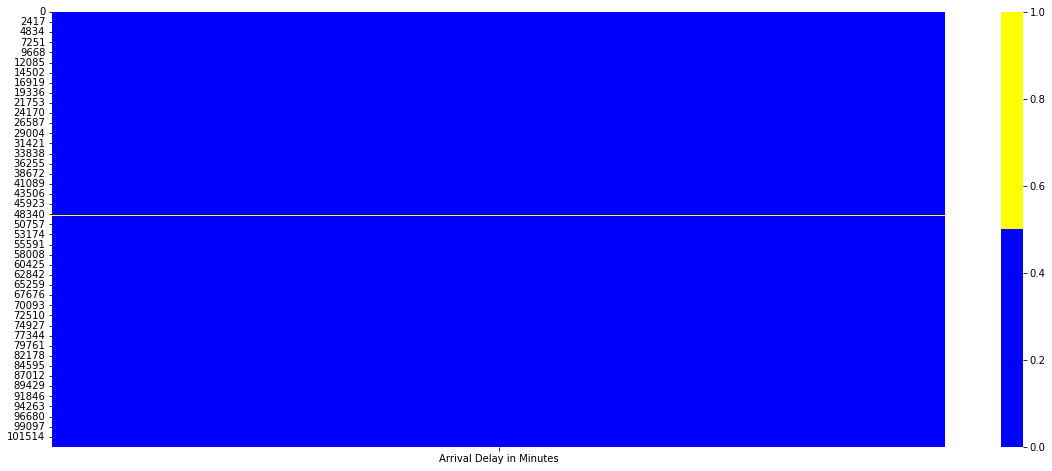

In [4]:
# Выводим суммарное количество пропусков
print('Суммарное количество пропусков в данных: {} \n'.format(airpass_df.isnull().sum().sum()))



# Построим тепловую карту пропусков
# Создаём функцию отображения пропущенных значений на тепловой карте
def missing_values_heatmap(data):
    
    # Рассчитываем количество пропусков
    cols_null_persent = data.isnull().mean() * 100
    cols_with_null = cols_null_persent[cols_null_persent > 0].sort_values(ascending = False)
    print(cols_with_null)
    
    # Задаём параметры графика
    colors = ['blue', 'yellow']
    fig = plt.figure(figsize = (20, 8))
    cols = cols_with_null.index
    
    # Строим тепловую карту
    ax = sns.heatmap(
        data = data[cols].isnull(),
        cmap = sns.color_palette(colors)
    )
    
    return ax


# Применяем полученную функцию к нашему датасету
missing_values_heatmap(airpass_df)

**Вывод:**

В среди всех наблюдений только признак `Arrival Delay in Minutes` содержит пропуски.

## <center> **`3.` Предобработка данных** 

#### $3.1$

Запоним пропуски в признаке `Arrival Delay in Minutes` медианным значением.

In [85]:
# Заполняем пропуски
airpass_df['Arrival Delay in Minutes'] = airpass_df['Arrival Delay in Minutes'].fillna(airpass_df['Arrival Delay in Minutes'].median())

# Выводим среднее значение
print('Среднее время задержки при прибытии в минутах: {:.2f}'.format(airpass_df['Arrival Delay in Minutes'].mean()))

Среднее время задержки при прибытии в минутах: 15.13


## <center> **`4.` Разведывательный анализ данных (EDA)**

#### $4.1$

Построим распределение признака `Age`.

In [86]:
# Создадим признак возрастных групп
airpass_df['Age_group'] = pd.cut(airpass_df.Age, bins = [0, 29, 40, 50, 60, 120], labels = ['<30', '30-40', '40-50', '50-60', '60+'])

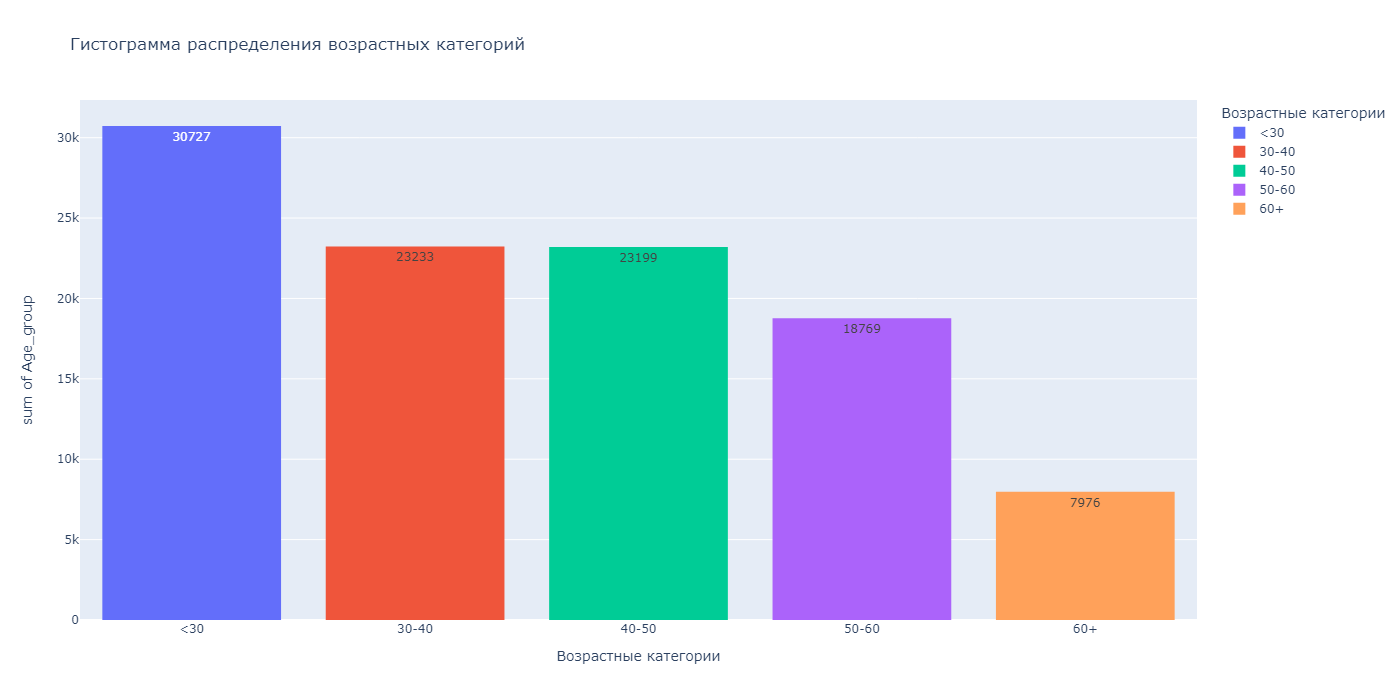

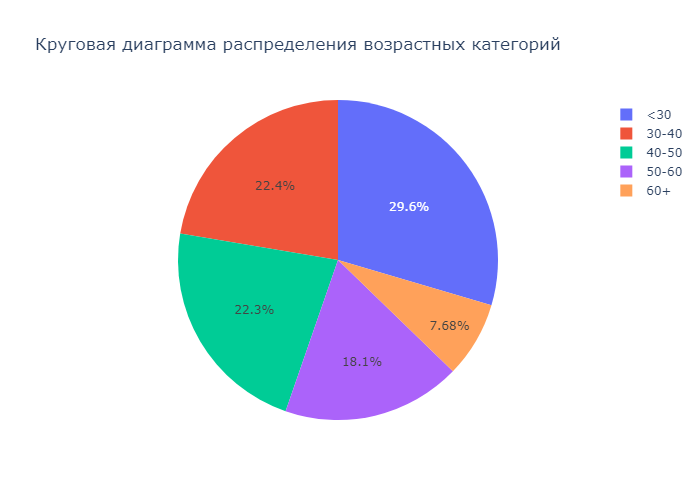

In [20]:
# Выделяем уникальные значения
age_distribution = airpass_df.Age_group.value_counts()



# Строим график
fig = px.histogram(
    data_frame = age_distribution,
    x = age_distribution.index,
    y = 'Age_group',
    color = age_distribution.index,
    orientation = 'v',
    height = 700,
    width = 1400,
    text_auto = 'Age_group',
    
    labels = {
        'index': 'Возрастные категории',
        'sum of Age_group': 'Количество пассажиров'
    },
    
    title = 'Гистограмма распределения возрастных категорий'
)

# Выводим график
fig.show('png')



# Строим круговую диаграмму
fig = px.pie(
    data_frame = age_distribution,
    values = 'Age_group',
    names = age_distribution.index,
    labels = 'Age_group',
    title = 'Круговая диаграмма распределения возрастных категорий'
)

# Выводим график
fig.show('png')

#### $4.2$

Построим распределение признака `satisfaction`.

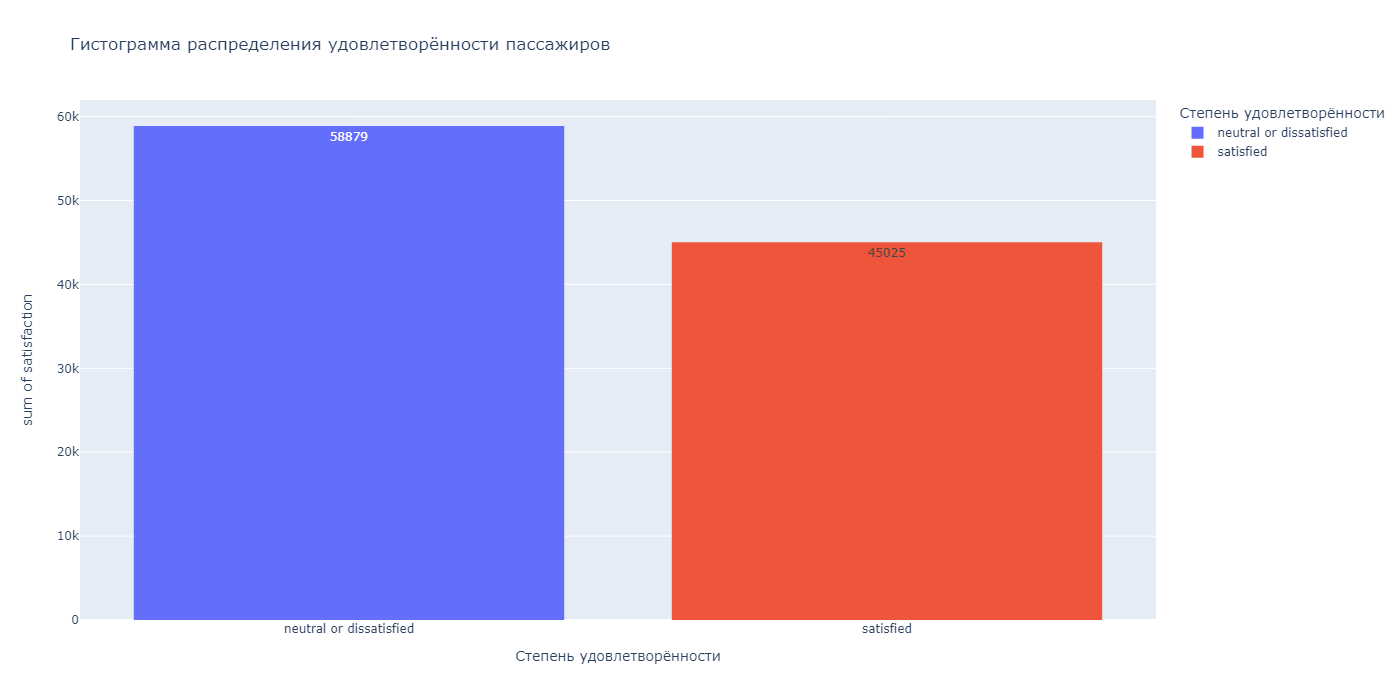

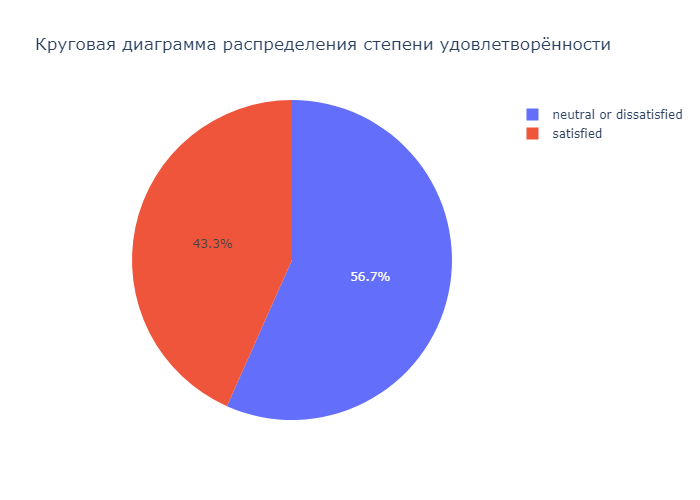

In [41]:
# Выделяем уникальные значения
satisfaction_distribution = airpass_df.satisfaction.value_counts()



# Строим гистограмму
fig = px.histogram(
    data_frame = satisfaction_distribution,
    x = satisfaction_distribution.index,
    y = 'satisfaction',
    color = satisfaction_distribution.index,
    height = 700,
    width = 1400,
    text_auto = 'satisfaction',
    
    labels = {
        'index': 'Степень удовлетворённости',
        'sum of satisfaction': 'Количество пассажиров'
    },
    
    title = 'Гистограмма распределения удовлетворённости пассажиров'
)

# Выводим график
fig.show('png')



# Строим круговую диаграмму
fig = px.pie(
    data_frame = satisfaction_distribution,
    values = 'satisfaction',
    names = satisfaction_distribution.index,
    labels = 'satisfaction',
    title = 'Круговая диаграмма распределения степени удовлетворённости'
)

# Выводим график
fig.show('png')

#### $4.3$

Построим распределение признака `Departure/Arrival time convenient`.

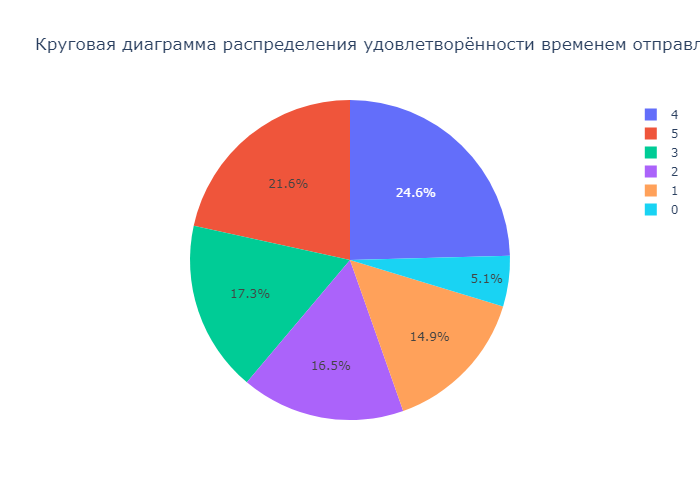

In [40]:
# Выделяем уникальные значения
time_distribution = airpass_df['Departure/Arrival time convenient'].value_counts()



# Строим круговую диаграмму
fig = px.pie(
    data_frame = time_distribution,
    values = 'Departure/Arrival time convenient',
    names = time_distribution.index,
    labels = 'Departure/Arrival time convenient',
    title = 'Круговая диаграмма распределения удовлетворённости временем отправления и прибытия'
)

# Выводим график
fig.show('png')

#### **Выводы:**

* Средний возраст большинства клиентов авиакомпаний ниже 30-ти лет (`30727 чел.` или `29.6%`);
* Наибольшее число пассажиров либо нейтральны, либо недовольны услугами (`58879 чел.` или `56.7%`).

#### $4.4$

Посмотрим, в каких категориях пассажиров превалировали удовлетворённые полетом клиенты.

Сравним удовлетворённость полётом мужчин и женщин.

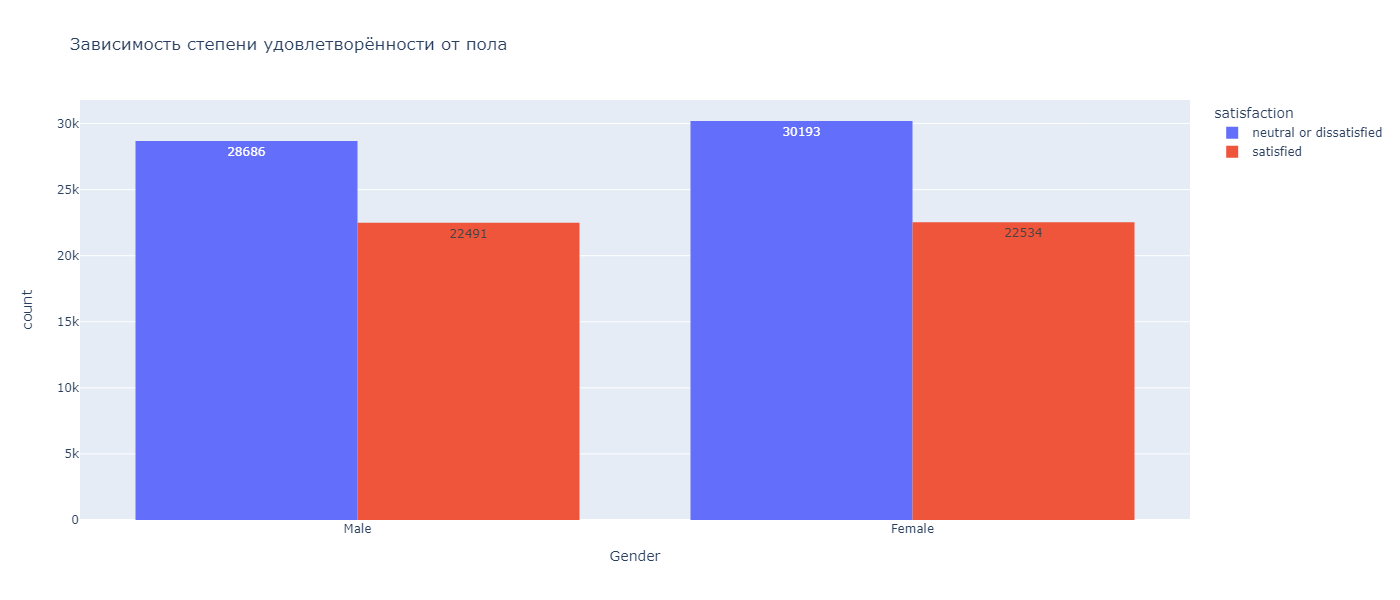

In [6]:
# Строим диаграмму
fig = px.histogram(
    data_frame = airpass_df,                                # DataFrame
    x = 'Gender',                                           # распределение по оси x
    color = 'satisfaction',                                 # цвет столбцов
    barmode = 'group',                                      # тип графика
    height = 600,                                           # высота
    width = 1400,                                           # ширина
    text_auto = 'satisfaction',                             # текст на графике
    title = 'Зависимость степени удовлетворённости от пола' # название графика
)

# Выводим график
fig.show('png')

#### $4.5$

Теперь сравним категории пассажиров в зависимости от их цели поездки.

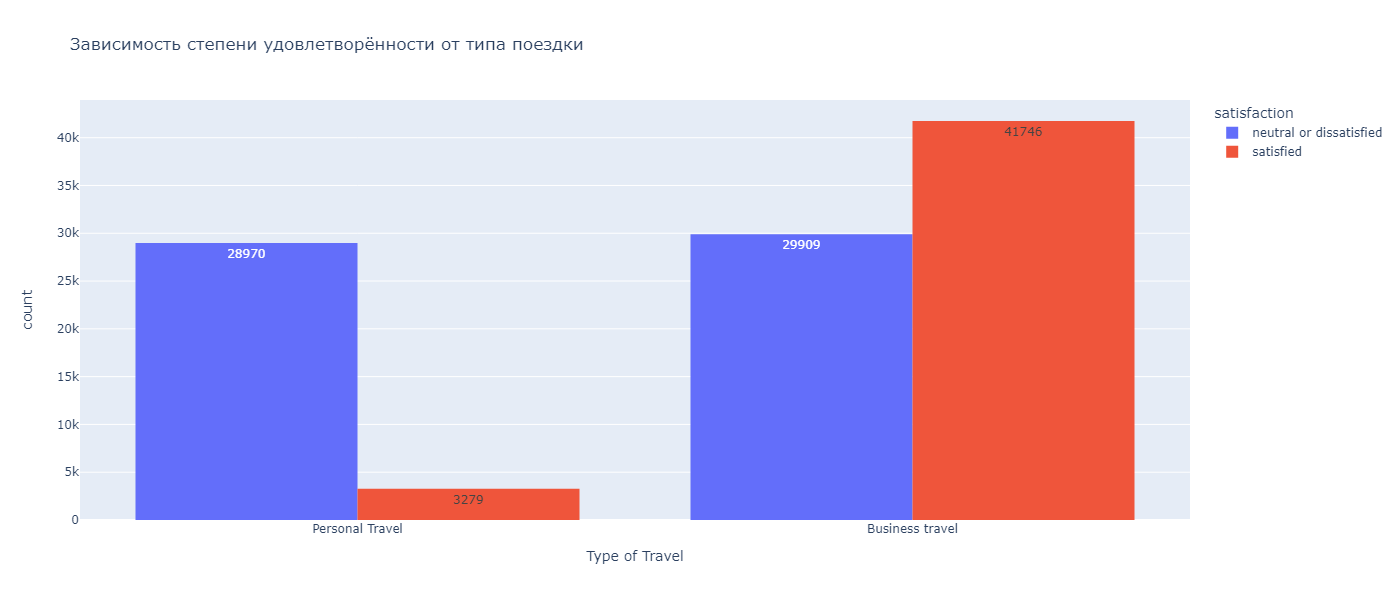

In [7]:
# Строим диаграмму
fig = px.histogram(
    data_frame = airpass_df,                                # DataFrame
    x = 'Type of Travel',                                   # распределение по оси x
    color = 'satisfaction',                                 # цвет столбцов
    barmode = 'group',                                      # тип графика
    height = 600,                                           # высота
    width = 1400,                                           # ширина
    text_auto = 'satisfaction',                             # текст на графике
    title = 'Зависимость степени удовлетворённости от типа поездки' # название графика
)

# Выводим график
fig.show('png')

#### $4.6$

Посмотрим, в каком туристическом классе наибольший процент довольных клиентов.

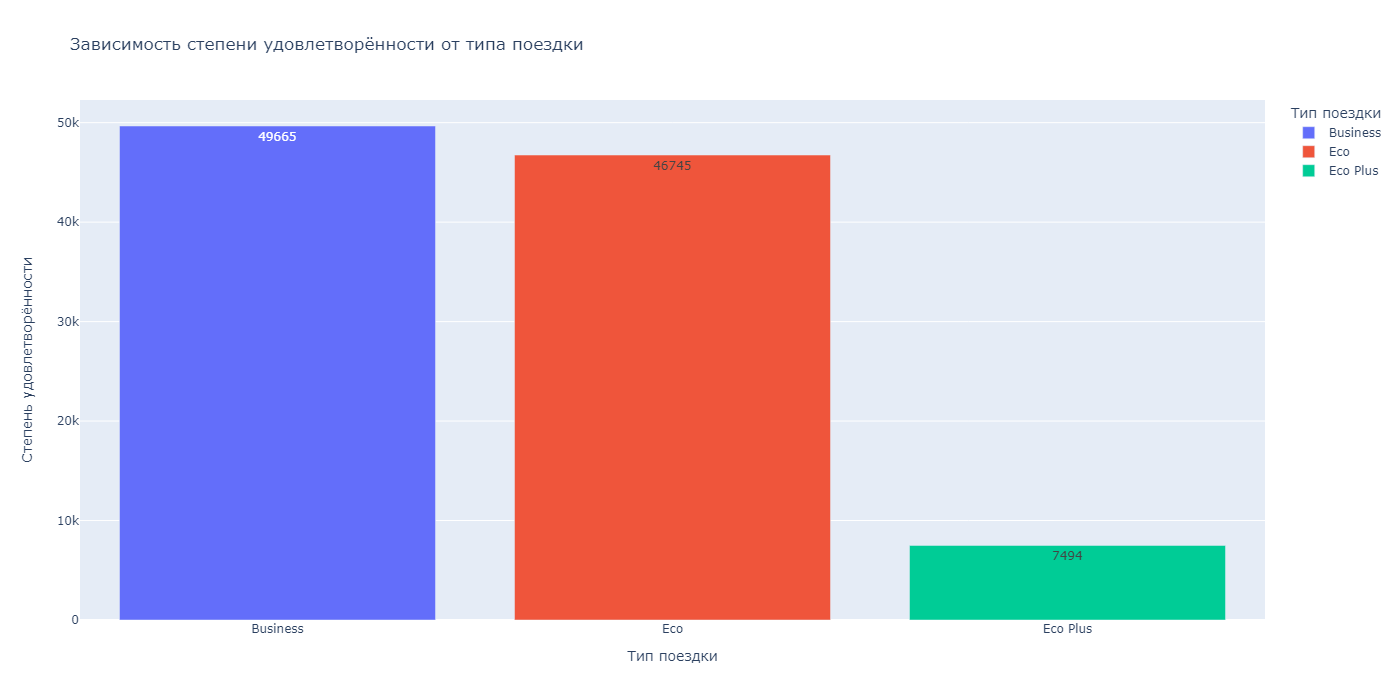

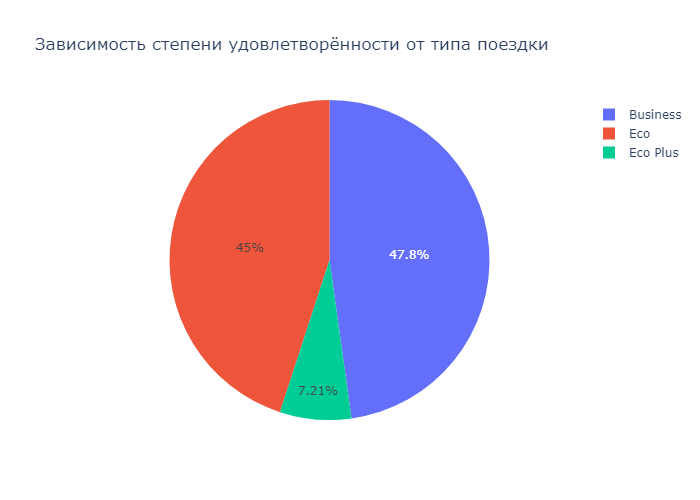

In [8]:
# Создаём DataFrame, в котором отразим зависимость степени удовлетворённости от типа поездки
class_group = airpass_df.groupby(
    by = 'Class',
    as_index = False
)[['satisfaction']].count()



# Строим диаграмму
fig = px.bar(
    data_frame = class_group,
    x = 'Class',
    y = 'satisfaction',
    color = 'Class',
    height = 700,
    width = 1400,
    text = 'satisfaction',
    
    labels = {
        'Class': 'Тип поездки',
        'satisfaction': 'Степень удовлетворённости'
    },
    
    title = 'Зависимость степени удовлетворённости от типа поездки'
)

# Выводим график
fig.show('png')



# Строим круговую диаграмму
fig = px.pie(
    data_frame = class_group,                                         # DataFrame
    values = 'satisfaction',                                          # значения на графике
    names = 'Class',                                                  # признак пола
    labels = 'Class',
    title = 'Зависимость степени удовлетворённости от типа поездки'   # название графика
)

# Выводим график
fig.show('png')

#### **Выводы:**

Из проведённого исследования можно заключить: 

* По уровню удовлетворённости услугами авиакомпаний больше **нейтрально настроенных/недовольных**; 
* Среди тех, кто летал в деловую поездку, довольных больше, чем среди тех, кто летал по личным делам;
* Наибольший процент довольных клиентов в *Business*-классе.

#### $4.7$

Выведем возрастные категории пассажиров, которые удовлетворены услугами авиаперевозчиков, и которые нейтральны либо неудовлетворены.

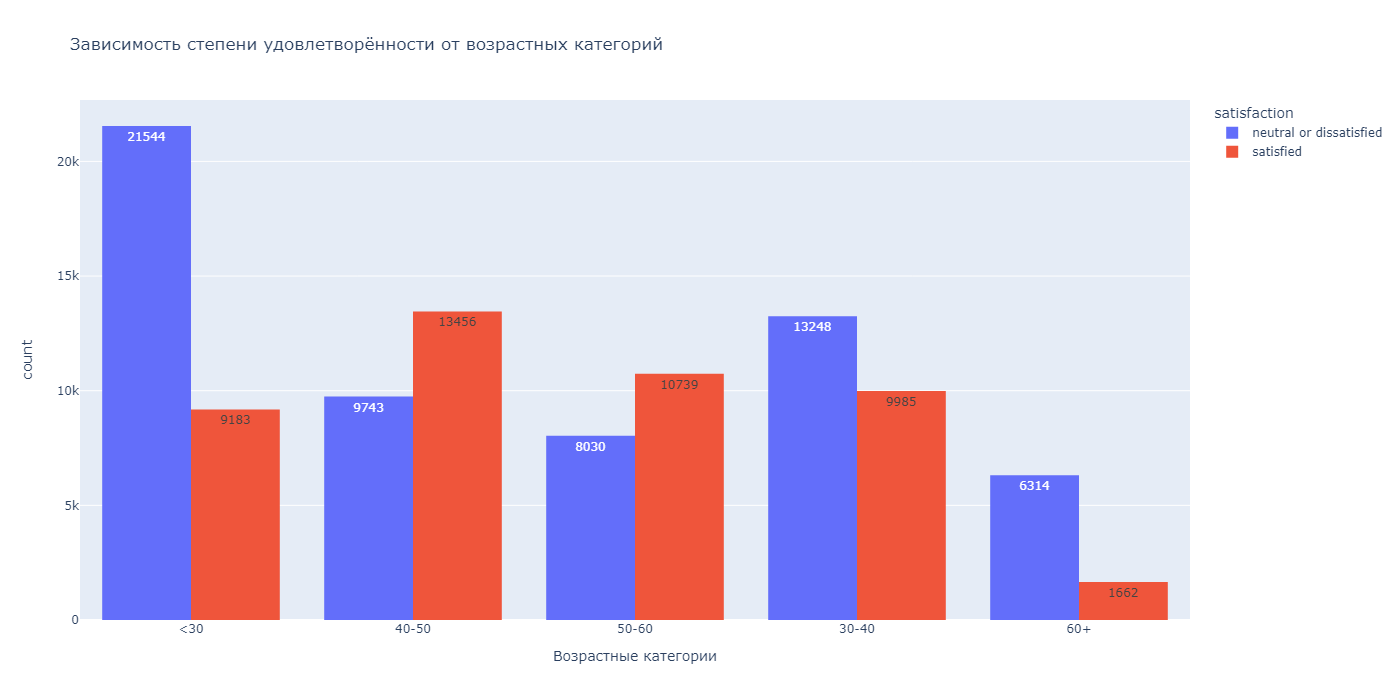

In [17]:
# Выбираем только удовлетворённых клиентов
satisfied_pass = airpass_df[airpass_df.satisfaction == 'satisfied']

# Строим гистограмму
fig = px.histogram(
    data_frame = airpass_df,
    x = 'Age_group',
    color = 'satisfaction',
    barmode = 'group',
    height = 700,
    width = 1400,
    text_auto = 'count',
    
    labels = {
        'Age_group': 'Возрастные категории',
        'count': 'Количество пассажиров'
    },
    
    title = 'Зависимость степени удовлетворённости от возрастных категорий'
)

# Выводим график
fig.show('png')

**Вывод:**

Из полученной гистограммы видно, что среди клиентов, которые нейтральны, либо неудовлетворены услугами - это пассажиры возраста до 30-ти лет.

Касаемо удовлетворённых клиентов - это пассажиры возраста от 40 до 50 лет.

## <center> **`5.` Отбор и преобразование признаков (Feature Engineering)**

#### $5.1$

Перекодируем признаки `satisfaction` и `Gender` в бинарные числовые.

In [87]:
# Создаём lambda-функции для замены строк на числа
row_bin_sat = lambda row: 1 if row == 'satisfied' else 0
row_bin_gen = lambda row: 1 if row == 'Female' else 0

# Кодируем признаки 
airpass_df.satisfaction = airpass_df.satisfaction.apply(row_bin_sat)
airpass_df.Gender = airpass_df.Gender.apply(row_bin_gen)

#### $5.2$

Признаки `Class`, `Type of Travel` и `Customer Type` закодируем горячим кодированием.

In [ ]:
# Создаём список категориальных признаков
cat_fit_list = ['Class', 'Type of Travel', 'Customer Type', 'Age_group']


# Создаём цикл по категориальным признакам
for column in airpass_df[cat_fit_list]:
    
    # Создаём экземпляр класса OneHotEncoder()
    encoder_type = ce.OneHotEncoder(cols = [column])
    
    # Кодируем признак column с помощью класса OneHotEncoder()
    type_one_hot = encoder_type.fit_transform(airpass_df[column])
    
    # Объединяем оба датасета
    airpass_df = pd.concat([airpass_df, type_one_hot], axis = 1)

#### $5.3$ 

Удаляем признаки типа *object*.

In [89]:
# Удаляем признаки типа object
object_columns = [features for features in airpass_df.columns if airpass_df[features].dtype == 'object']
airpass_df.drop(object_columns, axis = 1, inplace = True)

# Удаляем признаки Age и Age_group
airpass_df.drop(['Age', 'Age_group'], axis = 1, inplace = True)

print(f'Размер датасета после преобразования признаков: {airpass_df.shape}')

Размер датасета после преобразования признаков: (103904, 32)


#### $5.4$

Проверим признаки на коллинеарность.

Построим тепловую карту корреляций признаков.

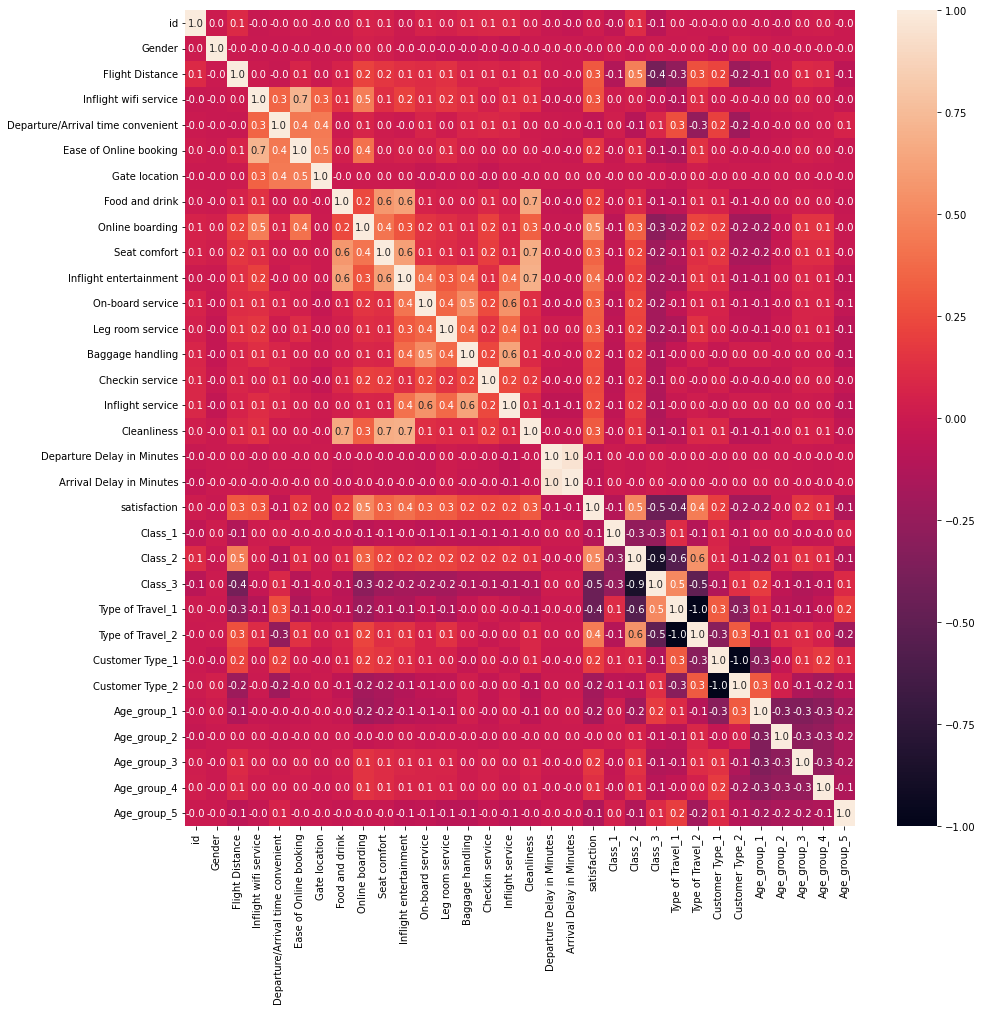

In [91]:
# Задаём размер графика
plt.rcParams['figure.figsize'] = (15, 15)


# Строим тепловую карту
sns.heatmap(
    data = airpass_df.corr(),
    annot = True,
    fmt = '.1f'
);

В данных присутствуют 4 связи с высокой корреляцией (уровень корреляции +- 0.7). 

Удалим по одному признаку из каждой связи.

In [ ]:
# Создаём список признаков имеющих высокую корреляцию
high_corr_features = ['Departure Delay in Minutes', 'Class_2', 'Type of Travel_2', 'Customer Type_2']

# Удаляем данные признаки
for column in airpass_df.columns:
    if column in high_corr_features:
        airpass_df = airpass_df.drop(column, axis = 1) 
        
        
# Выводим информацию о признаках
airpass_df.info()

#### $5.5$

Разделяем данные на обучающую и тестовую выборки в соотношении 80/20.

In [93]:
# Разделим наш DataFrame на матрицу наблюдений X и вектор правильных ответов y
X = airpass_df.drop('satisfaction', axis = 1)
y = airpass_df.satisfaction


# Разбиваем данные на обучающую и тестовую выборки в соотношении 80/20, 
# в качестве значения параметра random_state возьмём число 26
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=26)
print('Количество наблюдений в тестовой выборке: {}'.format(X_test.shape[0]))

Количество наблюдений в тестовой выборке: 20781


#### $5.6$

Исследуем распределение данных.

Построим график распределения признаков

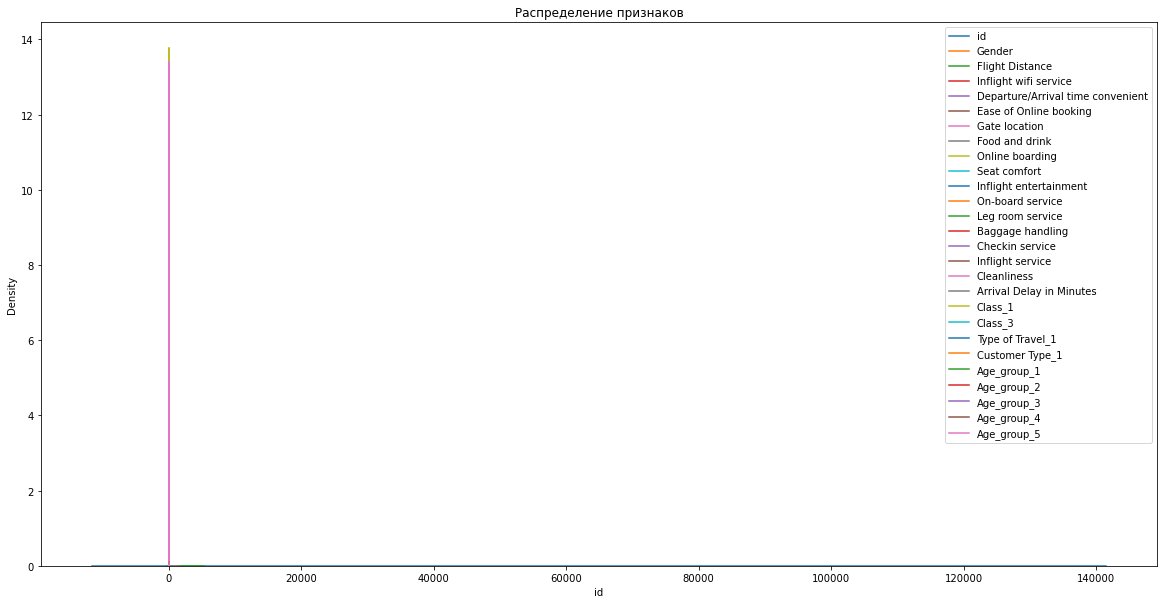

In [94]:
# Задаём параметры графика
fig, (ax) = plt.subplots(
    ncols = 1,                          # количество
    figsize = (20, 10)                  # размеры шрафика
)

ax.set_title('Распределение признаков') # наименование графика


# Строим график
for column in X_train.columns:
    sns.kdeplot(X_train[column], ax = ax, label = column)
    
# Выводим график
plt.legend()

Масштабируем данные используя метод *StandardScaler()* и с помощью него преобразуем и обучающую, и тестовую выборки.

In [95]:
# Инициализируем стандартизатор StandardScaler()
s_scaler = preprocessing.StandardScaler()

# Обучаем на тренировочном наборе данных
s_scaler.fit(X_train)

# Кодируем обучающий и тестовый наборы данных
X_train_s = s_scaler.transform(X_train)
X_test_s = s_scaler.transform(X_test)

# Преобразуем промежуточные массивы в датафреймы
X_train_s = pd.DataFrame(X_train_s, columns = list(X_train.columns))
X_test_s = pd.DataFrame(X_test_s, columns = list(X_test.columns))

Визуализируем данные

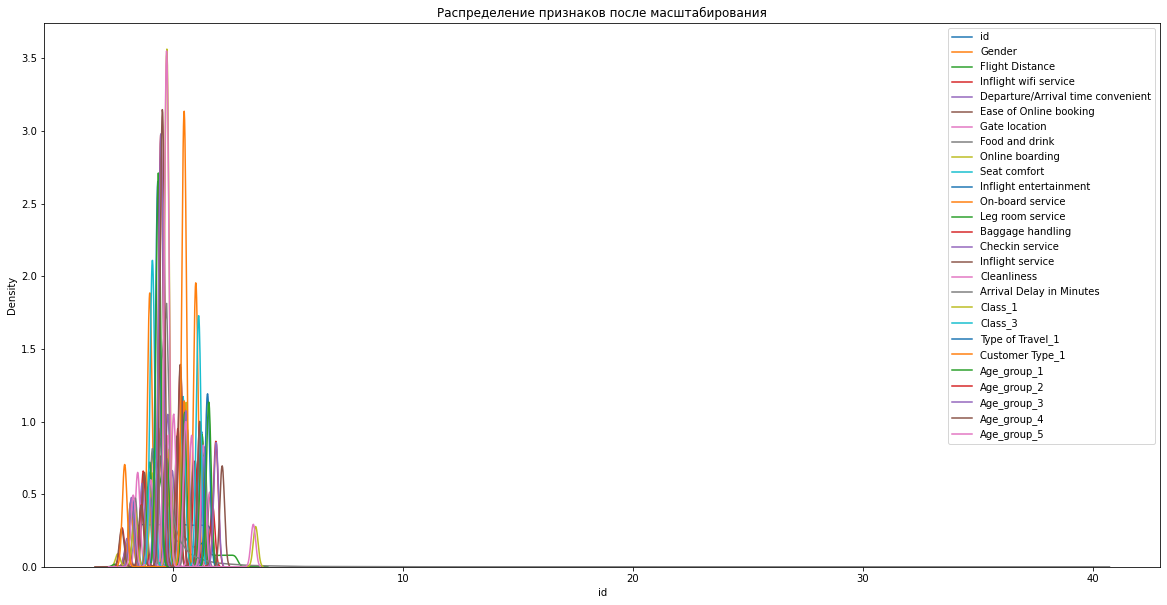

In [96]:
# Задаём параметры графика
fig, (ax) = plt.subplots(
    ncols = 1,              # количество графиков
    figsize = (20, 10)      # размеры шрафика
)

ax.set_title('Распределение признаков после масштабирования')  # наименование графика



# Строим график
for column in X_train_s.columns:
    sns.kdeplot(X_train_s[column], ax = ax, label = column)
    
# Выводим график
plt.legend()

## <center> **`6.` Построение и сравнение моделей (Machine Learning)**

#### $6.1$

Построим простейшую логистическую регрессию (без настройки гиперпараметров). Это будет та модель, с качеством которой мы будем сравнивать результаты, полученные далее.

В качестве ответа выведем значение метрики `f1_score` на тестовой выборке. Ответ **округлим до двух знаков после точки-разделителя**.

In [97]:
# Создаём модель класса LogisticRegression()
LR_model = linear_model.LogisticRegression()

# Обучаем модель на обучающей выборке
LR_model.fit(X_train_s, y_train)

# Делаем предсказание на обеих выборках
lr_y_train_pred = LR_model.predict(X_train_s)
lr_y_test_pred = LR_model.predict(X_test_s)

# Выводим значения метрики f1_score для обеих выборок
print('Значение метрики f1_score на тренировочной выборке: {:.3f}'.format(metrics.f1_score(lr_y_train_pred, y_train)))
print('Значение метрики f1_score на тестовой выборке: {:.3f}'.format(metrics.f1_score(lr_y_test_pred, y_test)))      

Значение метрики f1_score на тренировочной выборке: 0.854
Значение метрики f1_score на тестовой выборке: 0.856


#### $6.2$

Теперь перейдём к бустингу. Начнём с обучения первой модели — **AdaBoost**. В качестве базовой модели для неё возьмём решающее дерево с параметром `random_state = 26`.

Обучим **AdaBoost**, зафиксировав `random_state` со значением 26 и задав темп обучения 0.01. 

В качестве ответа выведем значение метрики `f1_score`. Ответ **округлим до трёх знаков после точки-разделителя**.

In [99]:
# Создаем объект класса бустинг
AB_model = ensemble.AdaBoostClassifier(
    
    estimator = tree.DecisionTreeClassifier(random_state = 26), # базовая модель
    random_state = 26,                                          # генератор случайных чисел
    learning_rate = 0.01                                        # темп обучения
    
)


# Обучаем модель на тренировочной выборке
AB_model.fit(X_train_s, y_train)

# Формируем предсказание для обучающей и тестовой выборки
ab_y_train_pred = AB_model.predict(X_train_s)
ab_y_test_pred = AB_model.predict(X_test_s)

# Выводим отчёт о метриках
print('Полный отчёт о метриках: \n\n{}'.format(metrics.classification_report(y_test, ab_y_test_pred)))

# Оцениваем качество по метрике F1 на обучающем и тестовом наборе
print('Значение метрики f1_score на тренировочной выборке: {:.3f}'.format(metrics.f1_score(y_train, ab_y_train_pred)))
print('Значение метрики f1_score на тестовой выборке: {:.3f}'.format(metrics.f1_score(y_test, ab_y_test_pred)))

Полный отчёт о метриках: 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     11673
           1       0.93      0.94      0.94      9108

    accuracy                           0.94     20781
   macro avg       0.94      0.94      0.94     20781
weighted avg       0.94      0.94      0.94     20781

Значение метрики f1_score на тренировочной выборке: 1.000
Значение метрики f1_score на тестовой выборке: 0.935


#### $6.3$

Перейдем к следующему алгоритму — градиентному бустингу.

Будем настраивать количество деревьев и темп обучения, делая перебор по сетке.

Используем для поиска оптимальных параметров **GridSearchCV**, а для ускорения работы алгоритма зададим параметр кросс-валидации, равный 3.

In [44]:
# Создаем объект класса градиентный бустинг
GBC_model = ensemble.GradientBoostingClassifier()


# Задаём сетку гиперпараметров
params = {
    'n_estimators': 2**np.arange(8),
    'learning_rate': 0.1**np.arange(3)
}


# Инициализируем поиск на сетке и обучаем его
GSC_model = model_selection.GridSearchCV(
    estimator = GBC_model,
    param_grid = params,
    cv = 3,
    scoring = metrics.make_scorer(metrics.f1_score),
    verbose = 5
)


# Обучаем модель
GSC_model.fit(X_train_s, y_train)

# Выводим список лучших параметров и значение метрики f1_score
print('Наилучшие значения гиперпараметров: {}'.format(GSC_model.best_params_))
print('Наилучшее значение метрики : {:.3f}'.format(GSC_model.best_score_))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END .learning_rate=1.0, n_estimators=1;, score=0.873 total time=   0.0s
[CV 2/3] END .learning_rate=1.0, n_estimators=1;, score=0.870 total time=   0.0s
[CV 3/3] END .learning_rate=1.0, n_estimators=1;, score=0.871 total time=   0.0s
[CV 1/3] END .learning_rate=1.0, n_estimators=2;, score=0.877 total time=   0.1s
[CV 2/3] END .learning_rate=1.0, n_estimators=2;, score=0.875 total time=   0.1s
[CV 3/3] END .learning_rate=1.0, n_estimators=2;, score=0.872 total time=   0.1s
[CV 1/3] END .learning_rate=1.0, n_estimators=4;, score=0.902 total time=   0.3s
[CV 2/3] END .learning_rate=1.0, n_estimators=4;, score=0.908 total time=   0.3s
[CV 3/3] END .learning_rate=1.0, n_estimators=4;, score=0.903 total time=   0.3s
[CV 1/3] END .learning_rate=1.0, n_estimators=8;, score=0.922 total time=   0.6s
[CV 2/3] END .learning_rate=1.0, n_estimators=8;, score=0.925 total time=   0.6s
[CV 3/3] END .learning_rate=1.0, n_estimators=8;

#### $6.4$

Теперь обучим алгоритм **XGBoost**. Определим его с параметром `random_state = 26`. Далее подсчитаем значение метрики `f1_score`.

In [100]:
# Создаем объект класса XGBoost
XGB_model = xgboost.XGBClassifier(random_state = 26)

# Обучаем модель
XGB_model.fit(X_train_s, y_train)

# Формируем предсказание для обучающей и тестовой выборки
xgb_y_train_pred = XGB_model.predict(X_train_s)
xgb_y_test_pred = XGB_model.predict(X_test_s)

# Выводим отчёт о метриках
print('Полный отчёт о метриках: \n\n{}'.format(metrics.classification_report(y_test, xgb_y_test_pred)))

# Оцениваем качество по метрике F1 на обучающем и тестовом наборе
print('Значение метрики f1_score на тренировочной выборке: {:.3f}'.format(metrics.f1_score(y_train, xgb_y_train_pred)))
print('Значение метрики f1_score на тестовой выборке: {:.3f}'.format(metrics.f1_score(y_test, xgb_y_test_pred)))

Полный отчёт о метриках: 

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11673
           1       0.97      0.94      0.96      9108

    accuracy                           0.96     20781
   macro avg       0.96      0.96      0.96     20781
weighted avg       0.96      0.96      0.96     20781

Значение метрики f1_score на тренировочной выборке: 0.974
Значение метрики f1_score на тестовой выборке: 0.958


#### $6.5$

Обучим алгоритм **CatBoost**. Как и **XGBoost**, будем обучать его с настройками по умолчанию и заданным `random_state = 26`. Далее подсчитаем значение метрики `f1_score`.

In [102]:
# Создаем объект класса CatBoost
CB_model = catboost.CatBoostClassifier(random_state = 26)

# Обучаем модель
CB_model.fit(X_train_s, y_train)

# Формируем предсказание для обучающей и тестовой выборки
cb_y_train_pred = CB_model.predict(X_train_s)
cb_y_test_pred = CB_model.predict(X_test_s)

# Выводим отчёт о метриках
print('Полный отчёт о метриках: \n\n{}'.format(metrics.classification_report(y_test, cb_y_test_pred)))

# Оцениваем качество по метрике F1 на обучающем и тестовом наборе
print('Значение метрики f1_score на тренировочной выборке: {:.3f}'.format(metrics.f1_score(y_train, cb_y_train_pred)))
print('Значение метрики f1_score на тестовой выборке: {:.3f}'.format(metrics.f1_score(y_test, cb_y_test_pred)))

Learning rate set to 0.068023
0:	learn: 0.6018138	total: 155ms	remaining: 2m 34s
1:	learn: 0.5020760	total: 167ms	remaining: 1m 23s
2:	learn: 0.4484943	total: 181ms	remaining: 1m
3:	learn: 0.4049064	total: 196ms	remaining: 48.7s
4:	learn: 0.3668045	total: 209ms	remaining: 41.6s
5:	learn: 0.3357238	total: 223ms	remaining: 37s
6:	learn: 0.3133745	total: 239ms	remaining: 33.9s
7:	learn: 0.2920144	total: 255ms	remaining: 31.7s
8:	learn: 0.2770587	total: 269ms	remaining: 29.6s
9:	learn: 0.2602769	total: 283ms	remaining: 28s
10:	learn: 0.2441309	total: 296ms	remaining: 26.6s
11:	learn: 0.2346453	total: 310ms	remaining: 25.5s
12:	learn: 0.2242116	total: 323ms	remaining: 24.5s
13:	learn: 0.2179372	total: 336ms	remaining: 23.6s
14:	learn: 0.2115783	total: 348ms	remaining: 22.8s
15:	learn: 0.2059741	total: 361ms	remaining: 22.2s
16:	learn: 0.1979996	total: 374ms	remaining: 21.6s
17:	learn: 0.1938953	total: 388ms	remaining: 21.2s
18:	learn: 0.1891714	total: 405ms	remaining: 20.9s
19:	learn: 0.185

#### $6.6$

Выведим матрицу ошибок для алгоритма, который получил наилучшие показатели качества модели на обучающей выборке.

Значения в матрице ошибок переведём в проценты от общего числа наблюдений в обучающей выборке и округлим до целых.

In [103]:
# Составляем матрицу
cm = get_confusion_matrix(CB_model, catboost.Pool(X_train_s, y_train))

# Считаем проценты
print(f'TN: {round(cm[0][0] / cm.sum() * 100)}%')
print(f'FP: {round(cm[1][0] / cm.sum() * 100)}%')
print(f'FN: {round(cm[0][1] / cm.sum() * 100)}%')
print(f'TP: {round(cm[1][1] / cm.sum() * 100)}%')

TN: 56%
FP: 2%
FN: 1%
TP: 42%


#### $6.7$

Вычислим признаки, которые оказывают большее влияние на целевую переменную по сравнению с другими.

Таблица важности признаков: 

                             features  importances
3               Inflight wifi service    24.114753
20                   Type of Travel_1    20.190748
8                     Online boarding     7.795647
21                    Customer Type_1     6.919860
14                    Checkin service     4.446789
13                   Baggage handling     4.079836
9                        Seat comfort     3.555479
19                            Class_3     3.122554
10             Inflight entertainment     3.119067
6                       Gate location     2.952040
15                   Inflight service     2.850691
0                                  id     2.094834
2                     Flight Distance     2.017968
5              Ease of Online booking     1.976105
16                        Cleanliness     1.912061
11                   On-board service     1.804747
4   Departure/Arrival time convenient     1.566191
12                   Leg room service     1.421902
2

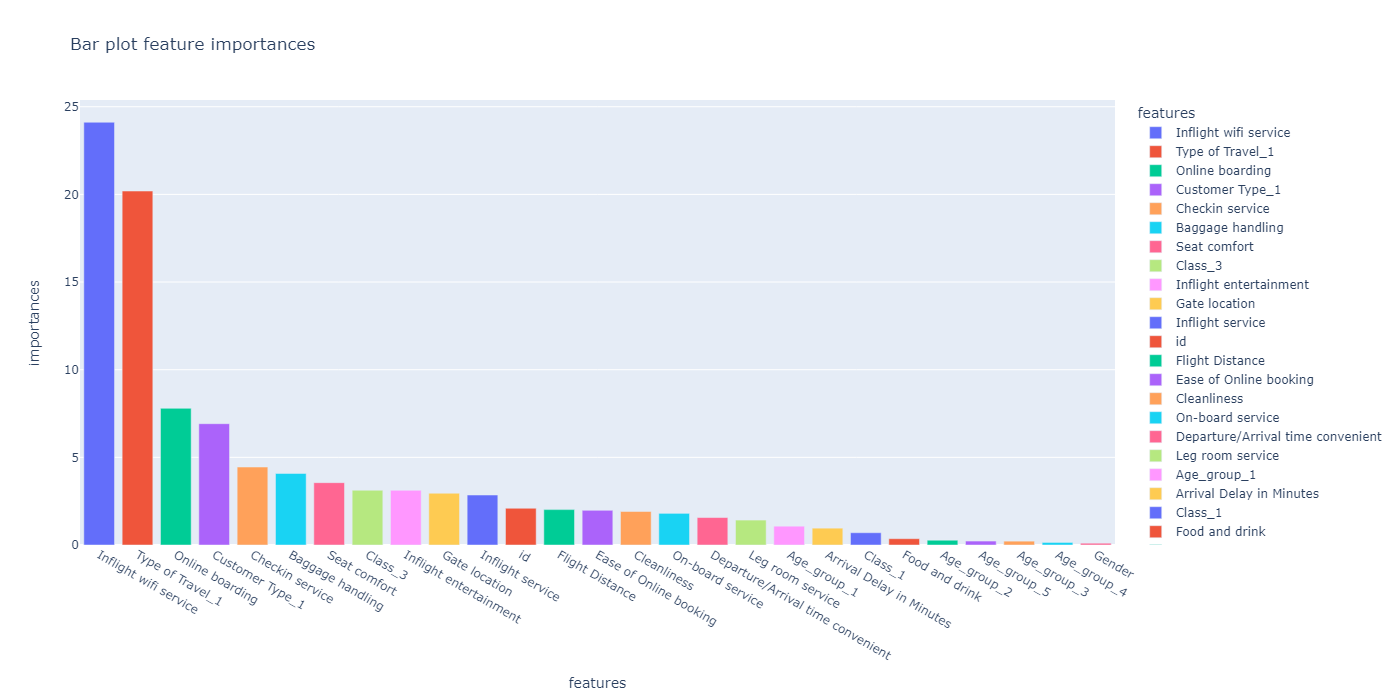

In [104]:
# Выделяем наиболее важные признаки
features = X.columns                                 # признаки
feature_importances = CB_model.feature_importances_  # важность признаков



# Создаём DataFrame, содержащий информацию о важности признаков
importances_data = pd.DataFrame({
    'features': features,               # признаки 
    'importances': feature_importances  # шкала важности признаков 
})

# Сортируем признаки по их важности
importances_data = importances_data.sort_values(by = 'importances', ascending = False)

# Выводим таблицу
print(f'Таблица важности признаков: \n\n{importances_data}')



# Строим столбчатую диаграмму
fig = px.bar(
    data_frame = importances_data,          # DataFrame
    x = 'features',                         # распределение по оси x
    y = 'importances',                      # распределение по оси y
    color = 'features',                     # цвет графика
    orientation = 'v',                      # вертиуальная ориентация графика
    height = 700,                           # высота
    width = 1400,                           # ширина
    
    labels = {                              # название осей
        'x': 'Features',
        'y': 'Importance'
    },
    
    title = 'Bar plot feature importances'  # название графика
)

fig.show('png')

## <center> **Вывод**

По окончании обработки данных, построения и тестирования различных моделей наилучший результат показали модели **CatBoostClassifier()** (значение метрики **f1_score** на обучающем и тестовом наборе равны: `0.973` и `0.958` соответственно) и **XGBClassifier** (значение метрики **f1_score** на обучающем и тестовом наборе равны: `0.974` и `0.959` соответственно). Таким образом, процент ошибки наших моделей составляет `2.6%`.